In [1]:
!hostname

n124.clstr


In [8]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob
import regionmask
import xarray as xr
import numpy as np
import rioxarray
import imageio
from rasterio import features
from shapely.vectorized import contains
from shapely.geometry import Polygon, MultiPolygon

In [9]:
def load_Xyrs_winter_dataset(start_winter_year, X):
    months_first_year = ['11', '12']  # Nov, Dec
    months_second_year = ['01', '02', '03']  # Jan to Mar

    all_file_list = []

    for i in range(X):
        year1 = start_winter_year + i   
        #defines the first year and moves to the correct directory to take Nov and Dec       
        year2 = year1 + 1                    
        #defines the second year of the winter and moves to the directory to take Jan through Mar

        path1 = f'/import/beegfs/CMIP6/wrf_era5/04km/{year1}'
        path2 = f'/import/beegfs/CMIP6/wrf_era5/04km/{year2}'

        for month in months_first_year:
            #for the months in the first year (Nov and Dec... add to the file list)
            pattern = f"era5_wrf_dscale_4km_{year1}-{month}-*.nc"
            file_list = sorted(glob.glob(os.path.join(path1, pattern)))
            if file_list:
                all_file_list.extend(file_list)
            else:
                print(f"{year1}-{month}: ERROR No files found")

        for month in months_second_year:
            #for the months in the second year (Jan through mar... add to the file list)
            pattern = f"era5_wrf_dscale_4km_{year2}-{month}-*.nc"
            file_list = sorted(glob.glob(os.path.join(path2, pattern)))
            if file_list:
                all_file_list.extend(file_list)
            else:
                print(f"{year2}-{month}: ERROR No files found")
                
    #this script is run within the script above..
    def select_vars(ds):
        #to shorted the amount of varaibles extracted, especially for multiyear analysis, only extract the variables necessary...
        return ds[['T2', 'SNOW', 'acsnow', 'rainnc', 'XLAT', 'XLONG']]

    if all_file_list:
        data = xr.open_mfdataset(all_file_list, combine='by_coords', preprocess=select_vars)
        print("X-year winter dataset opened and combined (selected variables only)!")
        return data
    else:
        raise ValueError("No files found across the X-year winter period!")


In [10]:
ds = load_Xyrs_winter_dataset(2017, 5) #this goes 2017/18, 2018/19, 2019/20, 2020/21, 2021/22  

T2 = ds['T2']
SNOW = ds['SNOW']
ACSNOW = ds['acsnow']
RAINNC = ds['rainnc']
lat = ds['XLAT']
lon = ds['XLONG']

X-year winter dataset opened and combined (selected variables only)!


In [11]:
def borough_land_mask(shapefile,data,lat,lon):
    mask = regionmask.mask_geopandas(shapefile, lon, lat) #defines the region of the mask/shapefile I want to filter 
    data_masked = data.where(~np.isnan(mask))  #filter out the data found outside of the shapefile to nan 
    
    os.chdir("/import/beegfs/CMIP6/wrf_era5")
    geo_em_path = "geo_em.d02.nc"
    geo = xr.open_dataset(geo_em_path) 
    landmask = geo['LANDMASK'] #filtering needed to fix data over rivers and lakes due to lack of snow accumlation in these spots
    landmask=landmask.squeeze(dim="Time")
    landmask_expanded = landmask.expand_dims(Time=data_masked.Time)

    data_fixed = data_masked.where(landmask_expanded== 1) 
    data_fixed = data_fixed.chunk(dict(south_north=-1, west_east=-1)) 
    data_filled = data_fixed.interpolate_na(dim="south_north", method="nearest", fill_value="extrapolate") #fills in the data surrounding the missing points from river land mask 
    data_filled = data_filled.interpolate_na(dim="west_east", method="nearest", fill_value="extrapolate") # fills in the data surrounding the missing points from river land mask 
    data_final = data_filled.where(~np.isnan(mask)) # again makes sure any surrounding points outside the boundary is nan 
    return data_final


In [12]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]
})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)
lat=ds['XLAT']
lon=ds['XLONG']

In [13]:
ds_borough=borough_land_mask(FNSB_boundary,ds,lat,lon)

In [14]:
def calculate_ros_events(data):
    """
    Calculate Rain-on-Snow (ROS) events from the accumulated winter dataset...
    Conditions for ROS:
    - Temperature (T2) > 273 K
    - Rain > 0.254 mm (RAIN = RAINNC - ACSNOW)
    - Snow depth > 25.4 mm (SNOW)

    Input Variables:
    - data: xarray.Dataset with variables: 'T2', 'SNOW', 'acsnow', 'rainnc'

    Outputs:
    -dict with:
        - ros_events: xarray.DataArray (boolean mask of ROS events)
        - ros_tally: total ROS hours per grid point
        - ros_counts: filtered count of ROS hours per grid point
        - ros_days_count: number of unique ROS days per grid point
    """
    T2 = data['T2']
    SNOW = data['SNOW']
    ACSNOW = data['acsnow']
    RAINNC = data['rainnc']
    
    lat=data['XLAT']
    lon=data['XLONG']
    
    RAIN=RAINNC-ACSNOW
    
    ros_events = (T2 > 273) & (RAIN > 0.254) & (SNOW > 25.4) #filters data for above criteria 
    
    dates = ros_events['Time'].dt.date.data #seperates date in Time variable (this step is needed for daily tallys)
    hours = ros_events['Time'].dt.hour.data #seperates hour in Time variable 

    ros_events = ros_events.assign_coords(
        Date=('Time', dates),
        Hour=('Time', hours)
    )

    ros_tally = ros_events.sum(dim='Time')  #counts each cell to where these 3 criteria match for each time step (HOURLY!) 

    ros_events_filtered = ros_events.where(ros_events != 0).dropna(dim='Time', how='all') #removes all times when ROS events did not occur, done to make dataset smaller 
    ros_counts = ros_events_filtered.count(dim='Time')

    ros_daily_counts = ros_events_filtered.groupby('Date').count(dim='Time')
    ros_days_count = ros_daily_counts.where(ros_daily_counts > 0).count(dim='Date') # gives each unique day per grid cell that experiences ROS events 

    return {
        'ros_events': ros_events, #a true/false mask at each grid point/ time step saying y or n to a ROS event occuring
        'ros_tally': ros_tally, #Total number of hours(time steps) where ROS conditions were met at each grid point
        'ros_counts': ros_counts, #similar to ros_tally but only has data where ROS is present no blank times 
        'ros_days_count': ros_days_count #counts the number of unique days when ROS events occurred at each grid point
    }

    

def get_winter_season_labels(time_index):
    """
    Assigns custom winter season labels like '2017-2018' to each timestamp.
    Only months Nov–Mar are included. Others get None.
    """
    labels = []
    for t in pd.to_datetime(time_index):
        if t.month in [11, 12]:
            labels.append(f"{t.year}-{t.year + 1}")
        elif t.month in [1, 2, 3]:
            labels.append(f"{t.year - 1}-{t.year}")
        else:
            labels.append(None)
    return np.array(labels)

def calculate_ros_by_winter_season(full_data):
    """
    Splits full dataset by winter season (Nov–Mar) and calculates ROS events per season.
    """
    # Get season labels for each time step and splits it into winter season for Nov through march 
    time_values = full_data['Time'].values
    season_labels = get_winter_season_labels(time_values)
    
    unique_seasons = sorted(set(season_labels) - {None})
    
    ros_tally_list = []
    ros_counts_list = []
    ros_days_count_list = []

    for season in unique_seasons:
        time_mask = season_labels == season
        selected_times = time_values[time_mask]
        seasonal_data = full_data.sel(Time=selected_times)
        
        ros_result = calculate_ros_events(seasonal_data)
        
        ros_tally_list.append(ros_result['ros_tally'].expand_dims(season=[season]))
        ros_counts_list.append(ros_result['ros_counts'].expand_dims(season=[season]))
        ros_days_count_list.append(ros_result['ros_days_count'].expand_dims(season=[season]))
    
    
    combined = xr.Dataset({
        'ros_tally': xr.concat(ros_tally_list, dim='season'),
        'ros_counts': xr.concat(ros_counts_list, dim='season'),
        'ros_days_count': xr.concat(ros_days_count_list, dim='season'),
    })

    return combined

In [15]:
seasonal_ros = calculate_ros_by_winter_season(ds_borough)

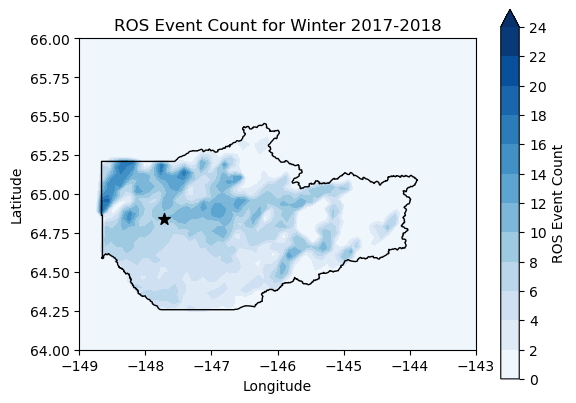

In [33]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, seasonal_ros['2017-2018']['ros_tally'],cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Event Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Event Count for Winter 2017-2018")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

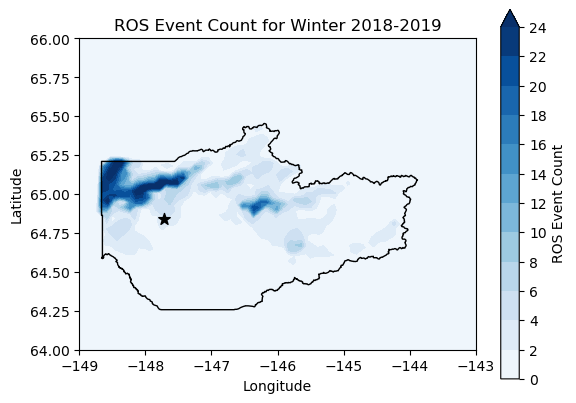

In [32]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, seasonal_ros['2018-2019']['ros_tally'],levels=levels,extend='max',cmap='Blues')
cbar = fig.colorbar(cf, ax=ax, label='ROS Event Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Event Count for Winter 2018-2019")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

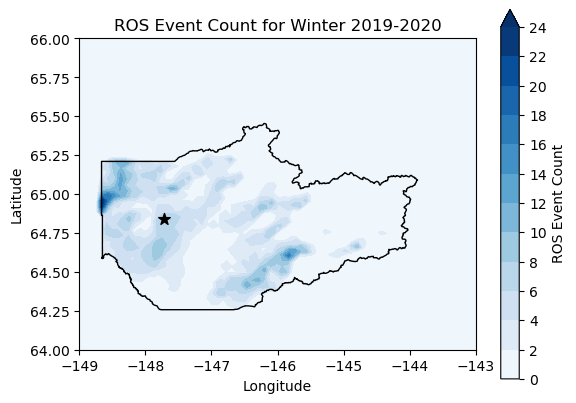

In [28]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, seasonal_ros['2019-2020']['ros_tally'],cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Event Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Event Count for Winter 2019-2020")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

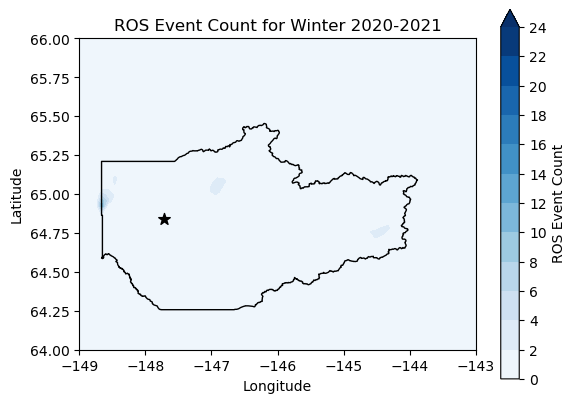

In [25]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, seasonal_ros['2020-2021']['ros_tally'],levels=levels,extend='max' ,cmap='Blues')
cbar = fig.colorbar(cf, ax=ax, label='ROS Event Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Event Count for Winter 2020-2021")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

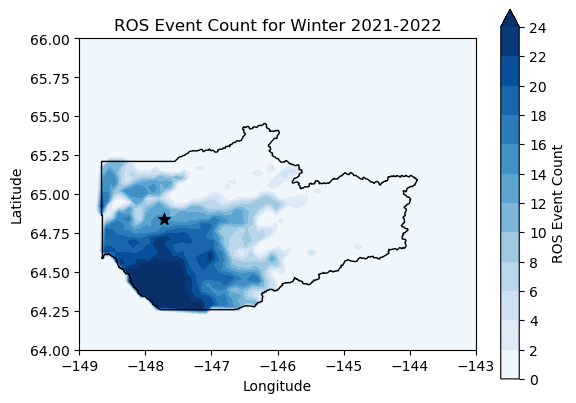

In [31]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, seasonal_ros['2021-2022']['ros_tally'],levels=levels,extend='max', cmap='Blues')
cbar = fig.colorbar(cf, ax=ax, label='ROS Event Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Event Count for Winter 2021-2022")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

Repeat all of the above for a different 5 year chunk 


In [36]:
ds_12_16 = load_Xyrs_winter_dataset(2012, 5) #this goes 2017/18, 2018/19, 2019/20, 2020/21, 2021/22  
#12/13 ,13/14, 14/15 , 15/16,  16/17
T2 = ds_12_16['T2']
SNOW = ds_12_16['SNOW']
ACSNOW = ds_12_16['acsnow']
RAINNC = ds_12_16['rainnc']
lat = ds_12_16['XLAT']
lon = ds_12_16['XLONG']

X-year winter dataset opened and combined (selected variables only)!


In [37]:
ds_borough_12_16=borough_land_mask(FNSB_boundary,ds_12_16,lat,lon)

In [38]:
seasonal_ros_12_16 = calculate_ros_by_winter_season(ds_borough_12_16)

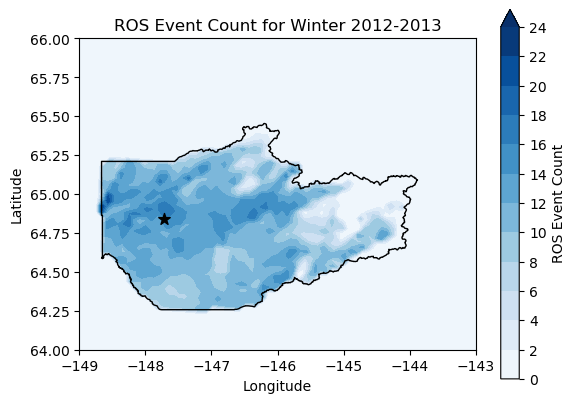

In [39]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, seasonal_ros_12_16['2012-2013']['ros_tally'],levels=levels,extend='max', cmap='Blues')
cbar = fig.colorbar(cf, ax=ax, label='ROS Event Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Event Count for Winter 2012-2013")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

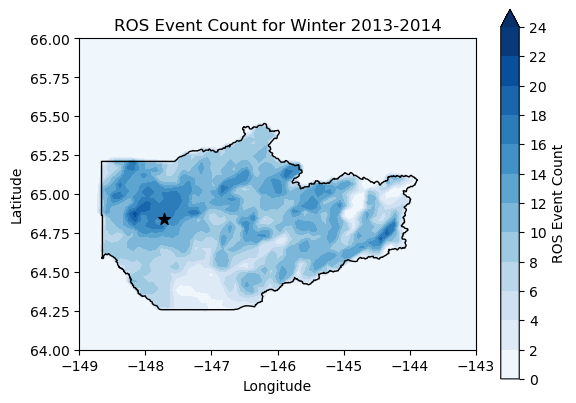

In [40]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, seasonal_ros_12_16['2013-2014']['ros_tally'],levels=levels,extend='max', cmap='Blues')
cbar = fig.colorbar(cf, ax=ax, label='ROS Event Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Event Count for Winter 2013-2014")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

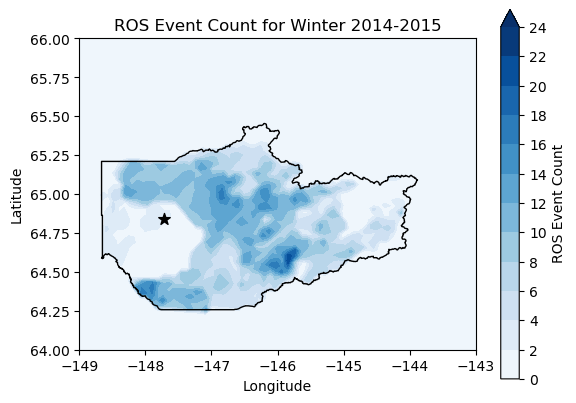

In [41]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, seasonal_ros_12_16['2014-2015']['ros_tally'],levels=levels,extend='max', cmap='Blues')
cbar = fig.colorbar(cf, ax=ax, label='ROS Event Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Event Count for Winter 2014-2015")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

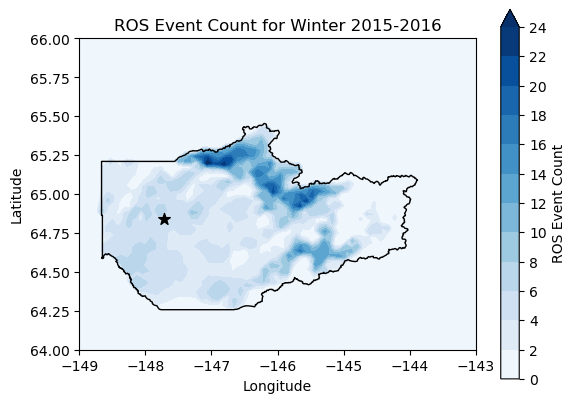

In [42]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, seasonal_ros_12_16['2015-2016']['ros_tally'],levels=levels,extend='max', cmap='Blues')
cbar = fig.colorbar(cf, ax=ax, label='ROS Event Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Event Count for Winter 2015-2016")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

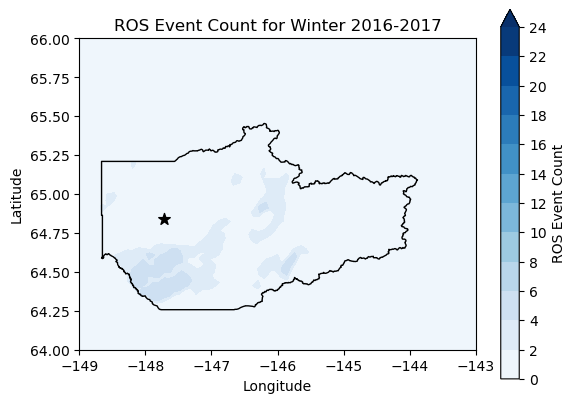

In [43]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, seasonal_ros_12_16['2016-2017']['ros_tally'],levels=levels,extend='max', cmap='Blues')
cbar = fig.colorbar(cf, ax=ax, label='ROS Event Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Event Count for Winter 2016-2017")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

Daily count analysis 

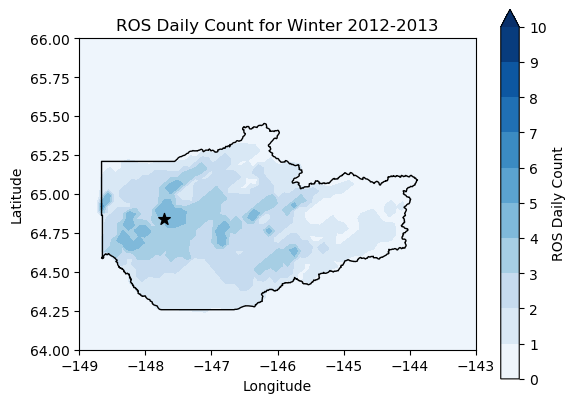

In [45]:
fig, ax = plt.subplots()  
levels = np.arange(0, 11, 1)
cf = ax.contourf(lon, lat, seasonal_ros_12_16['2012-2013']['ros_days_count'],cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Daily Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Daily Count for Winter 2012-2013")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

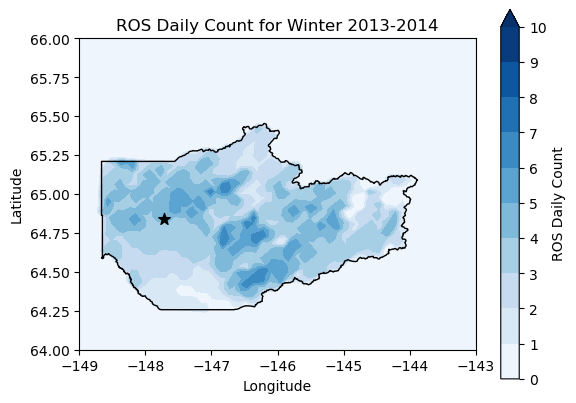

In [46]:
fig, ax = plt.subplots()  
levels = np.arange(0, 11, 1)
cf = ax.contourf(lon, lat, seasonal_ros_12_16['2013-2014']['ros_days_count'],cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Daily Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Daily Count for Winter 2013-2014")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

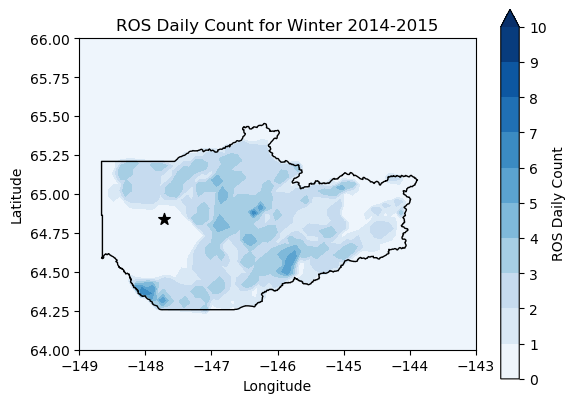

In [47]:
fig, ax = plt.subplots()  
levels = np.arange(0, 11, 1)
cf = ax.contourf(lon, lat, seasonal_ros_12_16['2014-2015']['ros_days_count'],cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Daily Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Daily Count for Winter 2014-2015")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

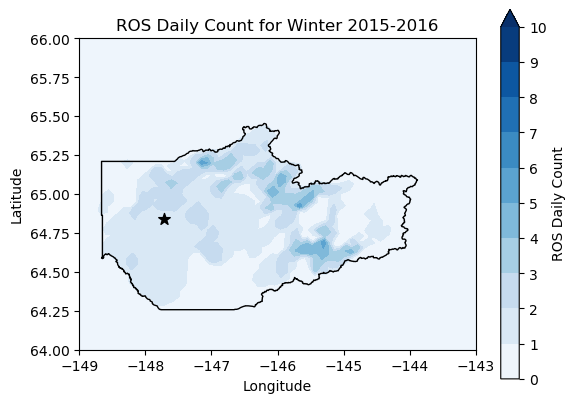

In [48]:
fig, ax = plt.subplots()  
levels = np.arange(0, 11, 1)
cf = ax.contourf(lon, lat, seasonal_ros_12_16['2015-2016']['ros_days_count'],cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Daily Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Daily Count for Winter 2015-2016")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

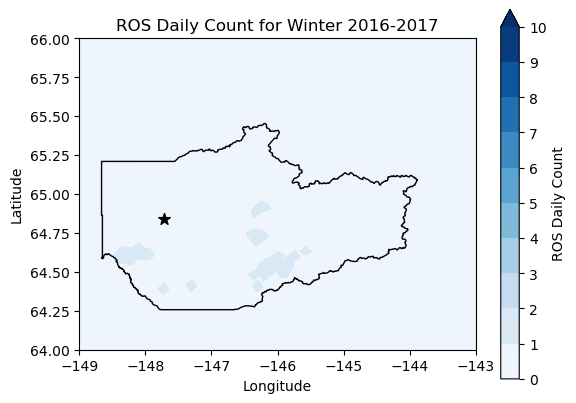

In [49]:
fig, ax = plt.subplots()  
levels = np.arange(0, 11, 1)
cf = ax.contourf(lon, lat, seasonal_ros_12_16['2016-2017']['ros_days_count'],cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Daily Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"ROS Daily Count for Winter 2016-2017")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

Averaging Years:
Daily then Hourly


In [50]:
average_daily_count_2017_2022 = np.mean([
    seasonal_ros['2017-2018']['ros_days_count'],
    seasonal_ros['2018-2019']['ros_days_count'],
    seasonal_ros['2019-2020']['ros_days_count'],
    seasonal_ros['2020-2021']['ros_days_count'],
    seasonal_ros['2021-2022']['ros_days_count']
], axis=0)

In [51]:
average_daily_count_2012_2016 = np.mean([
    seasonal_ros_12_16['2012-2013']['ros_days_count'],
    seasonal_ros_12_16['2013-2014']['ros_days_count'],
    seasonal_ros_12_16['2014-2015']['ros_days_count'],
    seasonal_ros_12_16['2015-2016']['ros_days_count'],
    seasonal_ros_12_16['2016-2017']['ros_days_count']
], axis=0)

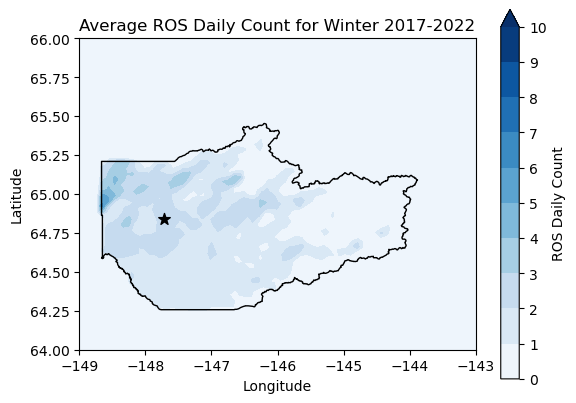

In [54]:
fig, ax = plt.subplots()  
levels = np.arange(0, 11, 1)
cf = ax.contourf(lon, lat, average_daily_count_2017_2022,cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Daily Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"Average ROS Daily Count for Winter 2017-2022")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [75]:
average_daily_count_2017_2022.max()

6.2

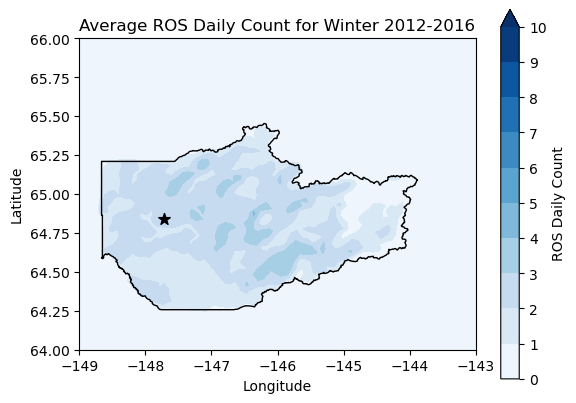

In [53]:
fig, ax = plt.subplots()  
levels = np.arange(0, 11, 1)
cf = ax.contourf(lon, lat, average_daily_count_2012_2016,cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Daily Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"Average ROS Daily Count for Winter 2012-2016")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [74]:
average_daily_count_2012_2016.max()

4.2

In [56]:
average_daily_count_2012_2021=np.mean([average_daily_count_2012_2016,average_daily_count_2017_2022],axis=0)

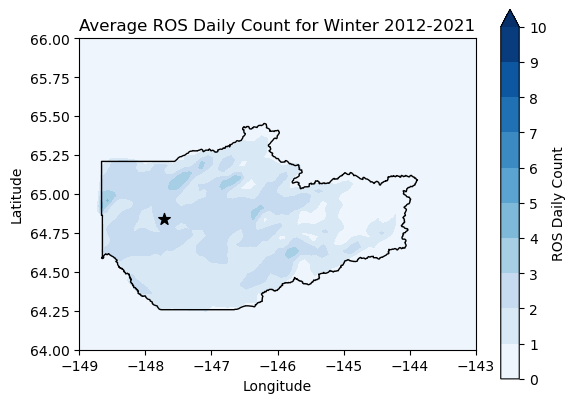

In [57]:
fig, ax = plt.subplots()  
levels = np.arange(0, 11, 1)
cf = ax.contourf(lon, lat, average_daily_count_2012_2021,cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Daily Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"Average ROS Daily Count for Winter 2012-2021")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [76]:
average_daily_count_2012_2021.max()

4.3

Hourly

In [ ]:
average_hourly_count_2017_2021 = np.mean([
    seasonal_ros['2017-2018']['ros_tally'],
    seasonal_ros['2018-2019']['ros_tally'],
    seasonal_ros['2019-2020']['ros_tally'],
    seasonal_ros['2020-2021']['ros_tally'],
    seasonal_ros['2021-2022']['ros_tally']
], axis=0)

In [60]:
average_hourly_count_2012_2016 = np.mean([
    seasonal_ros_12_16['2012-2013']['ros_tally'],
    seasonal_ros_12_16['2013-2014']['ros_tally'],
    seasonal_ros_12_16['2014-2015']['ros_tally'],
    seasonal_ros_12_16['2015-2016']['ros_tally'],
    seasonal_ros_12_16['2016-2017']['ros_tally']
], axis=0)

In [61]:
average_hourly_count_2012_2021=np.mean([average_hourly_count_2012_2016,average_hourly_count_2017_2021],axis=0)

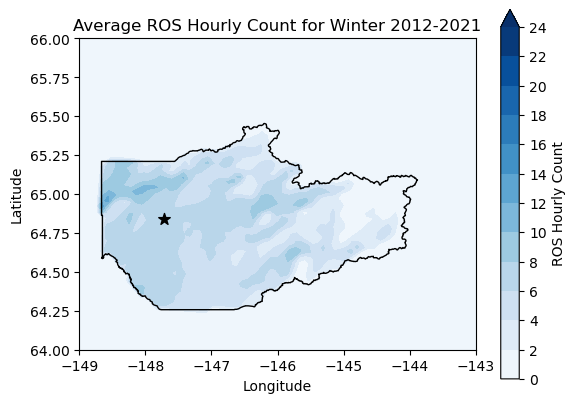

In [64]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, average_hourly_count_2012_2021,cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"Average ROS Hourly Count for Winter 2012-2021")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

Now can i subtract this average from the yearly values to find anomalous values? 

In [77]:
average_hourly_count_2012_2021.max()

13.200000000000001

5 more years

In [66]:
ds_7_11 = load_Xyrs_winter_dataset(2007, 5) 
#7/8 8/9 9/10 10/11 11/12
#previous 12/13 ,13/14, 14/15 , 15/16,  16/17
#previous  2017/18, 2018/19, 2019/20, 2020/21, 2021/22  

T2 = ds_7_11['T2']
SNOW = ds_7_11['SNOW']
ACSNOW = ds_7_11['acsnow']
RAINNC = ds_7_11['rainnc']
lat = ds_7_11['XLAT']
lon = ds_7_11['XLONG']

X-year winter dataset opened and combined (selected variables only)!


In [67]:
ds_borough_7_11=borough_land_mask(FNSB_boundary,ds_7_11,lat,lon)

In [69]:
seasonal_ros_7_11 = calculate_ros_by_winter_season(ds_borough_7_11)

In [82]:
average_hourly_count_2007_2011 = np.mean([
    seasonal_ros_7_11['2007-2008']['ros_tally'],
    seasonal_ros_7_11['2008-2009']['ros_tally'],
    seasonal_ros_7_11['2009-2010']['ros_tally'],
    seasonal_ros_7_11['2010-2011']['ros_tally'],
    seasonal_ros_7_11['2011-2012']['ros_tally']
], axis=0)

In [86]:
average_hourly_count_2007_2011.max()

14.0

In [78]:
average_daily_count_2007_2011 = np.mean([
    seasonal_ros_7_11['2007-2008']['ros_days_count'],
    seasonal_ros_7_11['2008-2009']['ros_days_count'],
    seasonal_ros_7_11['2009-2010']['ros_days_count'],
    seasonal_ros_7_11['2010-2011']['ros_days_count'],
    seasonal_ros_7_11['2011-2012']['ros_days_count']
], axis=0)

In [97]:
average_daily_count_2007_2011.max()

3.0

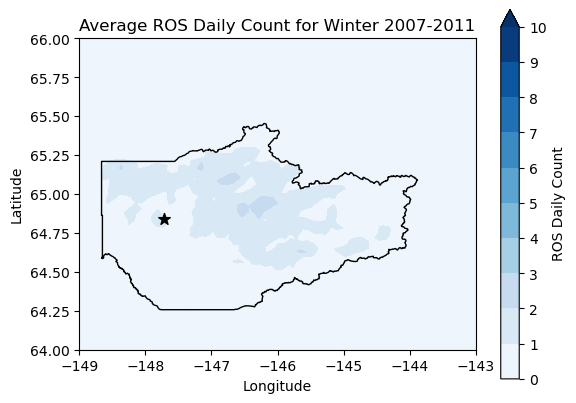

In [93]:
fig, ax = plt.subplots()  
levels = np.arange(0, 11, 1)
cf = ax.contourf(lon, lat, average_daily_count_2007_2011,cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Daily Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"Average ROS Daily Count for Winter 2007-2011")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

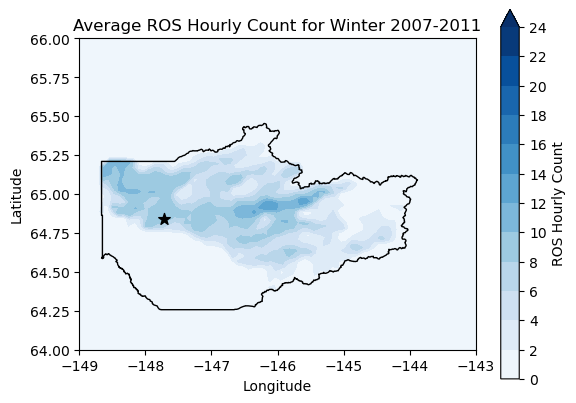

In [99]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, average_hourly_count_2007_2011,cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"Average ROS Hourly Count for Winter 2007-2011")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [100]:
average_hourly_count_2007_2011.max()

14.0

In [88]:
average_hourly_count_2007_2021=np.mean([average_hourly_count_2007_2011,average_hourly_count_2012_2016,average_hourly_count_2017_2022],axis=0)

In [90]:
average_daily_count_2007_2021=np.mean([average_daily_count_2007_2011,average_daily_count_2012_2016,average_daily_count_2017_2022],axis=0)

In [95]:
average_daily_count_2007_2021.max()

3.1999999999999997

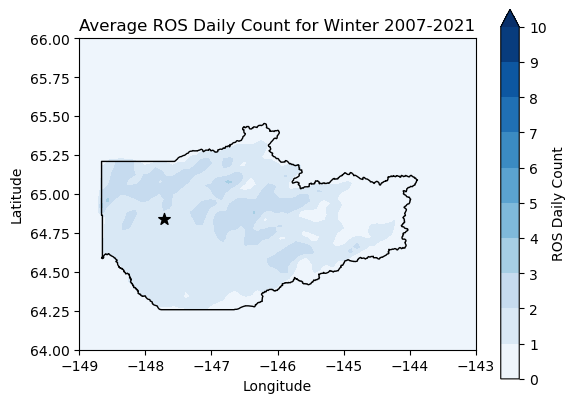

In [91]:
fig, ax = plt.subplots()  
levels = np.arange(0, 11, 1)
cf = ax.contourf(lon, lat, average_daily_count_2007_2021,cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Daily Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"Average ROS Daily Count for Winter 2007-2021")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

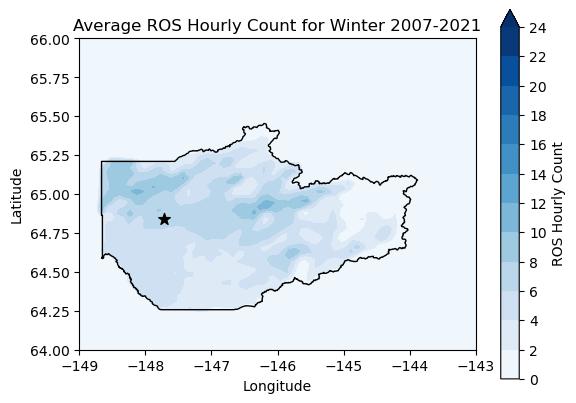

In [92]:
fig, ax = plt.subplots()  
levels = np.arange(0, 26, 2)
cf = ax.contourf(lon, lat, average_hourly_count_2007_2021,cmap='Blues', levels=levels, extend='max')
cbar = fig.colorbar(cf, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(levels) 
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"Average ROS Hourly Count for Winter 2007-2021")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [2]:
average_hourly_count_2007_2021.max()

NameError: name 'average_hourly_count_2007_2021' is not defined

In [111]:
max_value=seasonal_ros_7_11['2007-2008']['ros_days_count'].max().compute().item()


6

In [122]:
daily_max_values=[]

In [123]:
for year in ['2007-2008', '2008-2009', '2009-2010', '2010-2011','2011-2012']: 
    max_val = seasonal_ros_7_11[year]['ros_days_count'].max().compute().item()
    daily_max_values.append(max_val)

for year in ['2012-2013', '2013-2014', '2014-2015', '2015-2016','2016-2017']: 
    max_val = seasonal_ros_12_16[year]['ros_days_count'].max().compute().item()
    daily_max_values.append(max_val)
    
for year in ['2017-2018', '2018-2019', '2019-2020', '2020-2021','2021-2022']: 
    max_val = seasonal_ros[year]['ros_days_count'].max().compute().item()
    daily_max_values.append(max_val)

In [124]:
years=['2007-2008', '2008-2009', '2009-2010', '2010-2011','2011-2012','2012-2013',
'2013-2014', '2014-2015', '2015-2016','2016-2017', '2017-2018',
'2018-2019', '2019-2020', '2020-2021','2021-2022']

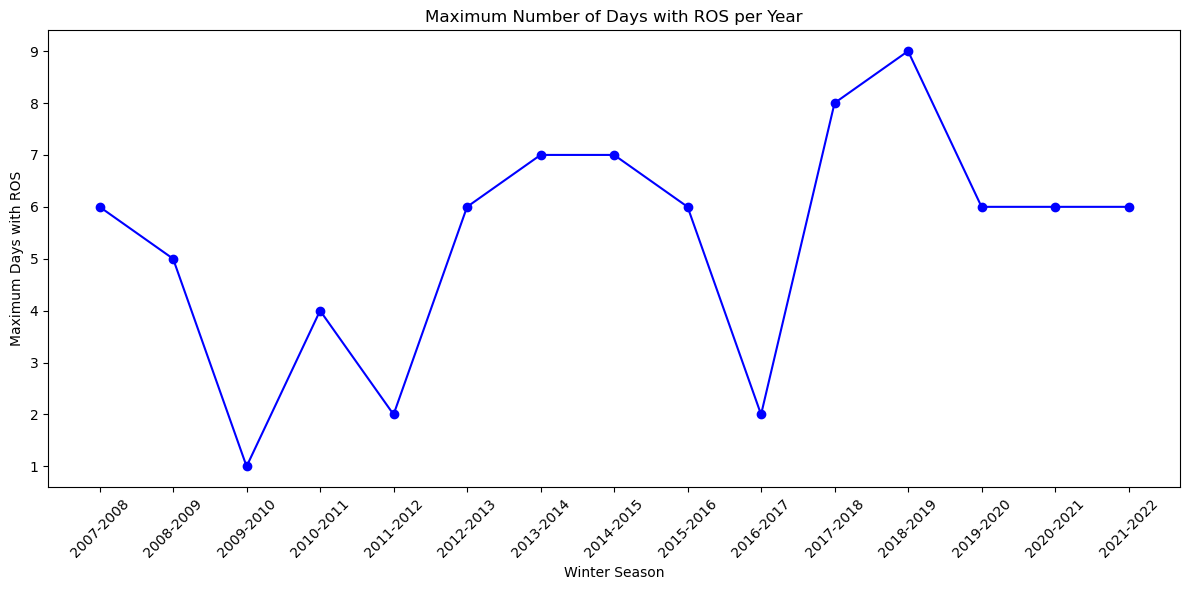

In [129]:
plt.figure(figsize=(12, 6))
plt.plot(years, daily_max_values, marker='o', linestyle='-', color='blue')
plt.title('Maximum Number of Days with ROS per Year')
plt.xlabel('Winter Season')
plt.ylabel('Maximum Days with ROS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [130]:
hourly_max_values=[]
years=['2007-2008', '2008-2009', '2009-2010', '2010-2011','2011-2012','2012-2013',
'2013-2014', '2014-2015', '2015-2016','2016-2017', '2017-2018',
'2018-2019', '2019-2020', '2020-2021','2021-2022']

for year in ['2007-2008', '2008-2009', '2009-2010', '2010-2011','2011-2012']: 
    max_val = seasonal_ros_7_11[year]['ros_tally'].max().compute().item()
    hourly_max_values.append(max_val)
print('2007 done')

2007 done


In [131]:
for year in ['2012-2013', '2013-2014', '2014-2015', '2015-2016','2016-2017']: 
    max_val = seasonal_ros_12_16[year]['ros_tally'].max().compute().item()
    hourly_max_values.append(max_val)
print('2012 done')

2012 done


In [132]:
for year in ['2017-2018', '2018-2019', '2019-2020', '2020-2021','2021-2022']: 
    max_val = seasonal_ros[year]['ros_tally'].max().compute().item()
    hourly_max_values.append(max_val)
print('2017 done')

2017 done


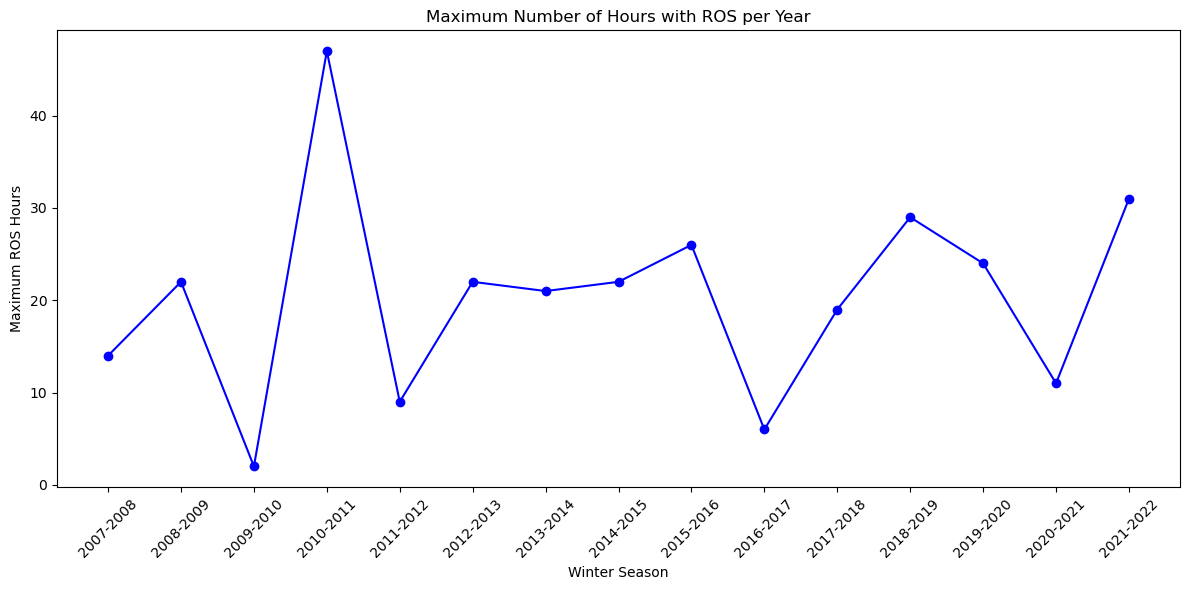

In [133]:
plt.figure(figsize=(12, 6))
plt.plot(years, hourly_max_values, marker='o', linestyle='-', color='blue')
plt.title('Maximum Number of Hours with ROS per Year')
plt.xlabel('Winter Season')
plt.ylabel('Maximum ROS Hours')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
for season in seasons:
    fig, ax = plt.subplots()
    levels = np.arange(0, 26, 2)
    data = seasonal_ros['ros_tally'].sel(season=season)
    cf = ax.contourf(lon, lat, data, cmap='Blues', levels=levels, extend='max')
    
    cbar = fig.colorbar(cf, ax=ax, label='ROS Event Count')
    cbar.set_ticks(levels)
    FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks')
    ax.set_title(f"ROS Event Count for Winter {season}")
    ax.set_xlim(-149, -143)
    ax.set_ylim(64, 66)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.show()